In [1]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'images_small/train/'
validation_dir = 'images_small/validation/'
test_dir = 'images_small/test/'

STD_SIZE = (100, 100)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

### Data preparation

In [11]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (68, 100, 100, 3)


### Model

In [12]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [14]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_2', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_2_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 2s - loss: 0.6846 - acc: 0.5700 - val_loss: 0.6561 - val_acc: 0.5319

Epoch 00001: val_loss improved from inf to 0.65613, saving model to tl_freeze_conv_base_data_aug_2
Epoch 2/1000
 - 1s - loss: 0.6922 - acc: 0.5348 - val_loss: 0.6598 - val_acc: 0.5957

Epoch 00002: val_loss did not improve from 0.65613
Epoch 3/1000
 - 1s - loss: 0.6676 - acc: 0.6413 - val_loss: 0.6538 - val_acc: 0.6167

Epoch 00003: val_loss improved from 0.65613 to 0.65377, saving model to tl_freeze_conv_base_data_aug_2
Epoch 4/1000
 - 1s - loss: 0.6159 - acc: 0.7377 - val_loss: 0.6068 - val_acc: 0.6596

Epoch 00004: val_loss improved from 0.65377 to 0.60675, saving model to tl_freeze_conv_base_data_aug_2
Epoch 5/1000
 - 1s - loss: 0.6501 - acc: 0.6368 - val_loss: 0.6331 - val_acc: 0.6170

Epoch 00005: val_loss did not improve from 0.60675
Epoch 6/1000
 - 1s - loss: 0.6224 - acc: 0.6564 - val_loss: 0.5990 - val_acc: 0.6383

Epoch 00006: val_loss improved from 0.60675 to 0.59902, saving model to tl_fr


Epoch 00053: val_loss did not improve from 0.26346
Epoch 54/1000
 - 1s - loss: 0.3886 - acc: 0.8128 - val_loss: 0.2847 - val_acc: 0.9574

Epoch 00054: val_loss did not improve from 0.26346
Epoch 55/1000
 - 1s - loss: 0.3926 - acc: 0.8128 - val_loss: 0.2861 - val_acc: 0.9167

Epoch 00055: val_loss did not improve from 0.26346
Epoch 56/1000
 - 1s - loss: 0.3408 - acc: 0.9100 - val_loss: 0.2789 - val_acc: 0.9149

Epoch 00056: val_loss did not improve from 0.26346
Epoch 57/1000
 - 1s - loss: 0.3745 - acc: 0.8840 - val_loss: 0.3200 - val_acc: 0.8936

Epoch 00057: val_loss did not improve from 0.26346
Epoch 58/1000
 - 1s - loss: 0.3305 - acc: 0.8789 - val_loss: 0.2574 - val_acc: 0.9362

Epoch 00058: val_loss improved from 0.26346 to 0.25736, saving model to tl_freeze_conv_base_data_aug_2
Epoch 59/1000
 - 1s - loss: 0.4287 - acc: 0.8683 - val_loss: 0.2799 - val_acc: 0.9333

Epoch 00059: val_loss did not improve from 0.25736
Epoch 60/1000
 - 1s - loss: 0.3422 - acc: 0.8688 - val_loss: 0.2620 

 - 1s - loss: 0.2905 - acc: 0.8789 - val_loss: 0.2430 - val_acc: 0.9362

Epoch 00110: val_loss did not improve from 0.17708
Epoch 111/1000
 - 1s - loss: 0.2711 - acc: 0.9050 - val_loss: 0.2441 - val_acc: 0.9167

Epoch 00111: val_loss did not improve from 0.17708
Epoch 112/1000
 - 1s - loss: 0.2795 - acc: 0.8991 - val_loss: 0.2289 - val_acc: 0.9149

Epoch 00112: val_loss did not improve from 0.17708
Epoch 113/1000
 - 1s - loss: 0.2650 - acc: 0.9344 - val_loss: 0.2372 - val_acc: 0.9149

Epoch 00113: val_loss did not improve from 0.17708
Epoch 114/1000
 - 1s - loss: 0.2603 - acc: 0.9092 - val_loss: 0.2198 - val_acc: 0.9574

Epoch 00114: val_loss did not improve from 0.17708
Epoch 115/1000
 - 1s - loss: 0.2733 - acc: 0.8890 - val_loss: 0.2400 - val_acc: 0.9167

Epoch 00115: val_loss did not improve from 0.17708
Epoch 116/1000
 - 1s - loss: 0.2830 - acc: 0.9092 - val_loss: 0.2043 - val_acc: 0.9574

Epoch 00116: val_loss did not improve from 0.17708
Epoch 117/1000
 - 1s - loss: 0.2855 - acc:


Epoch 00168: val_loss did not improve from 0.14412
Epoch 169/1000
 - 1s - loss: 0.2464 - acc: 0.9294 - val_loss: 0.2013 - val_acc: 0.8936

Epoch 00169: val_loss did not improve from 0.14412
Epoch 170/1000
 - 1s - loss: 0.2210 - acc: 0.9344 - val_loss: 0.2246 - val_acc: 0.9362

Epoch 00170: val_loss did not improve from 0.14412
Epoch 171/1000
 - 1s - loss: 0.2513 - acc: 0.8784 - val_loss: 0.2265 - val_acc: 0.9167

Epoch 00171: val_loss did not improve from 0.14412
Epoch 172/1000
 - 1s - loss: 0.1987 - acc: 0.9546 - val_loss: 0.1862 - val_acc: 0.9149

Epoch 00172: val_loss did not improve from 0.14412
Epoch 173/1000
 - 1s - loss: 0.2161 - acc: 0.9395 - val_loss: 0.2143 - val_acc: 0.9362

Epoch 00173: val_loss did not improve from 0.14412
Epoch 174/1000
 - 1s - loss: 0.2490 - acc: 0.9193 - val_loss: 0.1978 - val_acc: 0.9362

Epoch 00174: val_loss did not improve from 0.14412
Epoch 175/1000
 - 1s - loss: 0.2437 - acc: 0.8784 - val_loss: 0.2225 - val_acc: 0.9167

Epoch 00175: val_loss did 

 - 1s - loss: 0.2208 - acc: 0.9294 - val_loss: 0.2077 - val_acc: 0.9333

Epoch 00227: val_loss did not improve from 0.12067
Epoch 228/1000
 - 1s - loss: 0.1807 - acc: 0.9445 - val_loss: 0.2601 - val_acc: 0.8298

Epoch 00228: val_loss did not improve from 0.12067
Epoch 229/1000
 - 1s - loss: 0.1974 - acc: 0.9294 - val_loss: 0.1973 - val_acc: 0.9149

Epoch 00229: val_loss did not improve from 0.12067
Epoch 230/1000
 - 1s - loss: 0.2168 - acc: 0.9294 - val_loss: 0.1619 - val_acc: 0.9362

Epoch 00230: val_loss did not improve from 0.12067
Epoch 231/1000
 - 1s - loss: 0.2043 - acc: 0.9395 - val_loss: 0.2276 - val_acc: 0.8833

Epoch 00231: val_loss did not improve from 0.12067
Epoch 232/1000
 - 1s - loss: 0.1873 - acc: 0.9400 - val_loss: 0.1638 - val_acc: 0.9149

Epoch 00232: val_loss did not improve from 0.12067
Epoch 233/1000
 - 1s - loss: 0.1747 - acc: 0.9395 - val_loss: 0.2087 - val_acc: 0.8936

Epoch 00233: val_loss did not improve from 0.12067
Epoch 234/1000
 - 1s - loss: 0.2001 - acc:

 - 1s - loss: 0.1705 - acc: 0.9445 - val_loss: 0.2493 - val_acc: 0.8723

Epoch 00286: val_loss did not improve from 0.12067
Epoch 287/1000
 - 1s - loss: 0.1805 - acc: 0.9400 - val_loss: 0.1984 - val_acc: 0.9000

Epoch 00287: val_loss did not improve from 0.12067
Epoch 288/1000
 - 1s - loss: 0.1435 - acc: 0.9596 - val_loss: 0.2577 - val_acc: 0.8723

Epoch 00288: val_loss did not improve from 0.12067
Epoch 289/1000
 - 1s - loss: 0.1788 - acc: 0.9344 - val_loss: 0.1910 - val_acc: 0.8723

Epoch 00289: val_loss did not improve from 0.12067
Epoch 290/1000
 - 1s - loss: 0.1676 - acc: 0.9395 - val_loss: 0.1690 - val_acc: 0.9362

Epoch 00290: val_loss did not improve from 0.12067
Epoch 291/1000
 - 1s - loss: 0.1512 - acc: 0.9596 - val_loss: 0.2173 - val_acc: 0.8833

Epoch 00291: val_loss did not improve from 0.12067
Epoch 292/1000
 - 1s - loss: 0.1881 - acc: 0.9445 - val_loss: 0.1640 - val_acc: 0.9362

Epoch 00292: val_loss did not improve from 0.12067
Epoch 293/1000
 - 1s - loss: 0.1797 - acc:

### Results

In [15]:
model.evaluate(test_features, test_labels)

68/68 [==============================] - 1s 12ms/step


[0.21568718947031917, 0.8970588235294118]

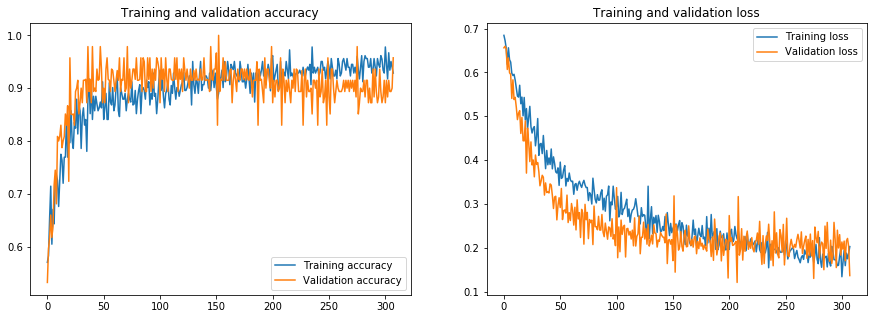

In [16]:
plot_accuracy_and_loss(history)

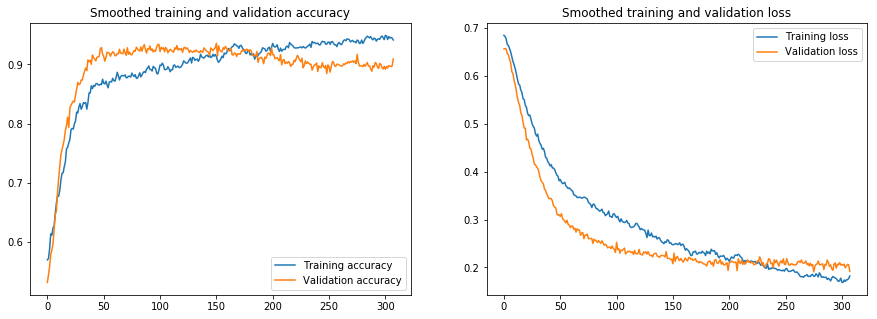

In [17]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

### Data preparation

In [19]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 353 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 119 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (119, 100, 100, 3)


### Model

In [20]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [21]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_3', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_3_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 3s - loss: 1.1186 - acc: 0.4235 - val_loss: 1.1188 - val_acc: 0.4000

Epoch 00001: val_loss improved from inf to 1.11876, saving model to tl_freeze_conv_base_data_aug_3
Epoch 2/1000
 - 2s - loss: 1.0697 - acc: 0.4388 - val_loss: 1.0632 - val_acc: 0.4433

Epoch 00002: val_loss improved from 1.11876 to 1.06320, saving model to tl_freeze_conv_base_data_aug_3
Epoch 3/1000
 - 2s - loss: 1.0493 - acc: 0.4802 - val_loss: 1.0600 - val_acc: 0.4536

Epoch 00003: val_loss improved from 1.06320 to 1.05995, saving model to tl_freeze_conv_base_data_aug_3
Epoch 4/1000
 - 2s - loss: 1.0210 - acc: 0.4463 - val_loss: 0.9838 - val_acc: 0.4948

Epoch 00004: val_loss improved from 1.05995 to 0.98385, saving model to tl_freeze_conv_base_data_aug_3
Epoch 5/1000
 - 2s - loss: 1.0161 - acc: 0.4624 - val_loss: 0.9587 - val_acc: 0.5670

Epoch 00005: val_loss improved from 0.98385 to 0.95874, saving model to tl_freeze_conv_base_data_aug_3
Epoch 6/1000
 - 2s - loss: 0.9772 - acc: 0.5405 - val_loss:


Epoch 00052: val_loss did not improve from 0.46415
Epoch 53/1000
 - 2s - loss: 0.5405 - acc: 0.8248 - val_loss: 0.5017 - val_acc: 0.8144

Epoch 00053: val_loss did not improve from 0.46415
Epoch 54/1000
 - 2s - loss: 0.5433 - acc: 0.8056 - val_loss: 0.4779 - val_acc: 0.8041

Epoch 00054: val_loss did not improve from 0.46415
Epoch 55/1000
 - 2s - loss: 0.5455 - acc: 0.7971 - val_loss: 0.4974 - val_acc: 0.7800

Epoch 00055: val_loss did not improve from 0.46415
Epoch 56/1000
 - 2s - loss: 0.5321 - acc: 0.8041 - val_loss: 0.4877 - val_acc: 0.7938

Epoch 00056: val_loss did not improve from 0.46415
Epoch 57/1000
 - 2s - loss: 0.5585 - acc: 0.8027 - val_loss: 0.5279 - val_acc: 0.8144

Epoch 00057: val_loss did not improve from 0.46415
Epoch 58/1000
 - 2s - loss: 0.5032 - acc: 0.8586 - val_loss: 0.4558 - val_acc: 0.8351

Epoch 00058: val_loss improved from 0.46415 to 0.45579, saving model to tl_freeze_conv_base_data_aug_3
Epoch 59/1000
 - 2s - loss: 0.5598 - acc: 0.7894 - val_loss: 0.4807 

 - 2s - loss: 0.4468 - acc: 0.8353 - val_loss: 0.4315 - val_acc: 0.8200

Epoch 00109: val_loss did not improve from 0.37473
Epoch 110/1000
 - 2s - loss: 0.4005 - acc: 0.8645 - val_loss: 0.4008 - val_acc: 0.8351

Epoch 00110: val_loss did not improve from 0.37473
Epoch 111/1000
 - 2s - loss: 0.4436 - acc: 0.8497 - val_loss: 0.3959 - val_acc: 0.8351

Epoch 00111: val_loss did not improve from 0.37473
Epoch 112/1000
 - 2s - loss: 0.4329 - acc: 0.8483 - val_loss: 0.4194 - val_acc: 0.8247

Epoch 00112: val_loss did not improve from 0.37473
Epoch 113/1000
 - 2s - loss: 0.3930 - acc: 0.8631 - val_loss: 0.3912 - val_acc: 0.8247

Epoch 00113: val_loss did not improve from 0.37473
Epoch 114/1000
 - 2s - loss: 0.4138 - acc: 0.8689 - val_loss: 0.4252 - val_acc: 0.8247

Epoch 00114: val_loss did not improve from 0.37473
Epoch 115/1000
 - 2s - loss: 0.4187 - acc: 0.8527 - val_loss: 0.4177 - val_acc: 0.8100

Epoch 00115: val_loss did not improve from 0.37473
Epoch 116/1000
 - 2s - loss: 0.4159 - acc:


Epoch 00167: val_loss did not improve from 0.31289
Epoch 168/1000
 - 2s - loss: 0.3487 - acc: 0.8689 - val_loss: 0.3742 - val_acc: 0.8247

Epoch 00168: val_loss did not improve from 0.31289
Epoch 169/1000
 - 2s - loss: 0.3781 - acc: 0.8557 - val_loss: 0.3578 - val_acc: 0.8400

Epoch 00169: val_loss did not improve from 0.31289
Epoch 170/1000
 - 2s - loss: 0.3818 - acc: 0.8689 - val_loss: 0.4134 - val_acc: 0.7526

Epoch 00170: val_loss did not improve from 0.31289
Epoch 171/1000
 - 2s - loss: 0.3882 - acc: 0.8468 - val_loss: 0.3740 - val_acc: 0.8247

Epoch 00171: val_loss did not improve from 0.31289
Epoch 172/1000
 - 2s - loss: 0.4157 - acc: 0.8366 - val_loss: 0.3925 - val_acc: 0.8041

Epoch 00172: val_loss did not improve from 0.31289
Epoch 173/1000
 - 2s - loss: 0.3350 - acc: 0.8969 - val_loss: 0.3455 - val_acc: 0.8557

Epoch 00173: val_loss did not improve from 0.31289
Epoch 174/1000
 - 2s - loss: 0.3719 - acc: 0.8763 - val_loss: 0.3638 - val_acc: 0.8041

Epoch 00174: val_loss did 

### Results

In [22]:
model.evaluate(test_features, test_labels)

119/119 [==============================] - 0s 4ms/step


[0.39071423466466054, 0.8739495838389677]

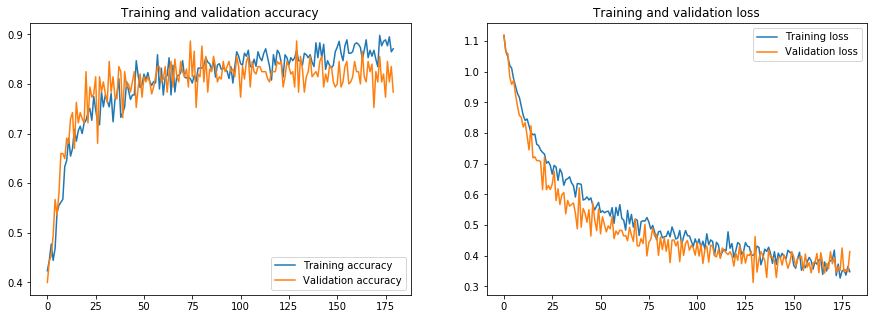

In [23]:
plot_accuracy_and_loss(history)

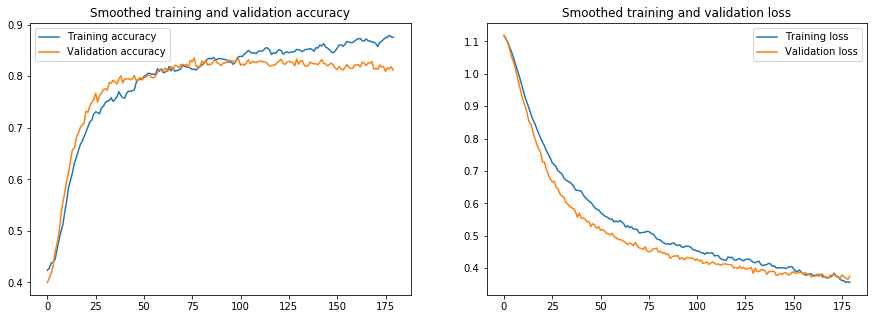

In [24]:
plot_smoothed_acc_and_loss(history, 0.8)

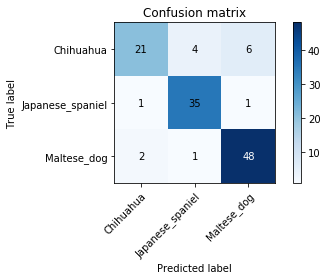

In [25]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

### Data preparation

In [0]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 570 images belonging to 5 classes.
Found 190 images belonging to 5 classes.
Found 192 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (192, 100, 100, 3)


### Model

In [0]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

W0629 09:51:12.892268  7624 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 09:51:12.913869  7624 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 09:51:12.916869  7624 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 09:51:12.937870  7624 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0629 09:51:13.204683  7624 depreca

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_5', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_5_history', 'wb') as f:
    pickle.dump(history.history, f)

W0629 09:52:30.949294  7624 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 09:52:31.021298  7624 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1000
 - 6s - loss: 1.6455 - acc: 0.2643 - val_loss: 1.6223 - val_acc: 0.3000

Epoch 00001: val_loss improved from inf to 1.62226, saving model to tl_freeze_conv_base_data_aug_5
Epoch 2/1000
 - 4s - loss: 1.5853 - acc: 0.2840 - val_loss: 1.5561 - val_acc: 0.3176

Epoch 00002: val_loss improved from 1.62226 to 1.55609, saving model to tl_freeze_conv_base_data_aug_5
Epoch 3/1000
 - 4s - loss: 1.5437 - acc: 0.3054 - val_loss: 1.5474 - val_acc: 0.3000

Epoch 00003: val_loss improved from 1.55609 to 1.54736, saving model to tl_freeze_conv_base_data_aug_5
Epoch 4/1000
 - 4s - loss: 1.5524 - acc: 0.3018 - val_loss: 1.5156 - val_acc: 0.3353

Epoch 00004: val_loss improved from 1.54736 to 1.51560, saving model to tl_freeze_conv_base_data_aug_5
Epoch 5/1000
 - 4s - loss: 1.5174 - acc: 0.3429 - val_loss: 1.5042 - val_acc: 0.3235

Epoch 00005: val_loss improved from 1.51560 to 1.50418, saving model to tl_freeze_conv_base_data_aug_5
Epoch 6/1000
 - 4s - loss: 1.4785 - acc: 0.3500 - val_loss:

 - 4s - loss: 1.0523 - acc: 0.6035 - val_loss: 1.0275 - val_acc: 0.6167

Epoch 00051: val_loss did not improve from 1.01893
Epoch 52/1000
 - 4s - loss: 1.0778 - acc: 0.5785 - val_loss: 1.0251 - val_acc: 0.6059

Epoch 00052: val_loss did not improve from 1.01893
Epoch 53/1000
 - 4s - loss: 1.0623 - acc: 0.6052 - val_loss: 1.0545 - val_acc: 0.6000

Epoch 00053: val_loss did not improve from 1.01893
Epoch 54/1000
 - 4s - loss: 1.0379 - acc: 0.6071 - val_loss: 1.0066 - val_acc: 0.6235

Epoch 00054: val_loss improved from 1.01893 to 1.00656, saving model to tl_freeze_conv_base_data_aug_5
Epoch 55/1000
 - 4s - loss: 1.0740 - acc: 0.5982 - val_loss: 1.0661 - val_acc: 0.6000

Epoch 00055: val_loss did not improve from 1.00656
Epoch 56/1000
 - 4s - loss: 1.0598 - acc: 0.6000 - val_loss: 0.9273 - val_acc: 0.6235

Epoch 00056: val_loss improved from 1.00656 to 0.92726, saving model to tl_freeze_conv_base_data_aug_5
Epoch 57/1000
 - 4s - loss: 1.0052 - acc: 0.6073 - val_loss: 0.9976 - val_acc: 0.6

 - 4s - loss: 0.8645 - acc: 0.6911 - val_loss: 0.9111 - val_acc: 0.6176

Epoch 00109: val_loss did not improve from 0.87843
Epoch 110/1000
 - 4s - loss: 0.8913 - acc: 0.6679 - val_loss: 0.9265 - val_acc: 0.6176

Epoch 00110: val_loss did not improve from 0.87843
Epoch 111/1000
 - 4s - loss: 0.9058 - acc: 0.6679 - val_loss: 0.9170 - val_acc: 0.6111

Epoch 00111: val_loss did not improve from 0.87843
Epoch 112/1000
 - 4s - loss: 0.8651 - acc: 0.6857 - val_loss: 0.9231 - val_acc: 0.5941

Epoch 00112: val_loss did not improve from 0.87843
Epoch 113/1000
 - 4s - loss: 0.9075 - acc: 0.6733 - val_loss: 0.9613 - val_acc: 0.5706

Epoch 00113: val_loss did not improve from 0.87843
Epoch 114/1000
 - 4s - loss: 0.8932 - acc: 0.6642 - val_loss: 0.8759 - val_acc: 0.6647

Epoch 00114: val_loss improved from 0.87843 to 0.87593, saving model to tl_freeze_conv_base_data_aug_5
Epoch 115/1000
 - 4s - loss: 0.8977 - acc: 0.6750 - val_loss: 0.8887 - val_acc: 0.6176

Epoch 00115: val_loss did not improve fro


Epoch 00166: val_loss did not improve from 0.79907
Epoch 167/1000
 - 4s - loss: 0.8116 - acc: 0.7142 - val_loss: 0.8607 - val_acc: 0.6176

Epoch 00167: val_loss did not improve from 0.79907
Epoch 168/1000
 - 4s - loss: 0.7989 - acc: 0.7124 - val_loss: 0.8838 - val_acc: 0.6529

Epoch 00168: val_loss did not improve from 0.79907
Epoch 169/1000
 - 4s - loss: 0.7704 - acc: 0.7248 - val_loss: 0.8947 - val_acc: 0.5824

Epoch 00169: val_loss did not improve from 0.79907
Epoch 170/1000
 - 4s - loss: 0.7509 - acc: 0.7339 - val_loss: 0.8760 - val_acc: 0.6294

Epoch 00170: val_loss did not improve from 0.79907
Epoch 171/1000
 - 4s - loss: 0.7693 - acc: 0.7267 - val_loss: 0.9029 - val_acc: 0.6000

Epoch 00171: val_loss did not improve from 0.79907
Epoch 172/1000
 - 4s - loss: 0.7905 - acc: 0.7089 - val_loss: 0.9050 - val_acc: 0.6176

Epoch 00172: val_loss did not improve from 0.79907
Epoch 173/1000
 - 4s - loss: 0.7675 - acc: 0.7482 - val_loss: 0.8443 - val_acc: 0.6588

Epoch 00173: val_loss did 


Epoch 00225: val_loss did not improve from 0.74887
Epoch 226/1000
 - 4s - loss: 0.6935 - acc: 0.7696 - val_loss: 0.8755 - val_acc: 0.6529

Epoch 00226: val_loss did not improve from 0.74887
Epoch 227/1000
 - 4s - loss: 0.6971 - acc: 0.7625 - val_loss: 0.9587 - val_acc: 0.6059

Epoch 00227: val_loss did not improve from 0.74887
Epoch 228/1000
 - 4s - loss: 0.7421 - acc: 0.7304 - val_loss: 0.8070 - val_acc: 0.6824

Epoch 00228: val_loss did not improve from 0.74887
Epoch 229/1000
 - 4s - loss: 0.7336 - acc: 0.7412 - val_loss: 0.8851 - val_acc: 0.6118

Epoch 00229: val_loss did not improve from 0.74887
Epoch 230/1000
 - 4s - loss: 0.7075 - acc: 0.7465 - val_loss: 0.8511 - val_acc: 0.6471

Epoch 00230: val_loss did not improve from 0.74887
Epoch 231/1000
 - 4s - loss: 0.7554 - acc: 0.7161 - val_loss: 0.8969 - val_acc: 0.6222

Epoch 00231: val_loss did not improve from 0.74887
Epoch 232/1000
 - 4s - loss: 0.7110 - acc: 0.7662 - val_loss: 0.7973 - val_acc: 0.6588

Epoch 00232: val_loss did 


Epoch 00284: val_loss did not improve from 0.74887
Epoch 285/1000
 - 4s - loss: 0.7153 - acc: 0.7410 - val_loss: 0.8385 - val_acc: 0.6706

Epoch 00285: val_loss did not improve from 0.74887
Epoch 286/1000
 - 4s - loss: 0.6665 - acc: 0.7731 - val_loss: 0.9116 - val_acc: 0.6176

Epoch 00286: val_loss did not improve from 0.74887
Epoch 287/1000
 - 4s - loss: 0.6938 - acc: 0.7465 - val_loss: 0.8384 - val_acc: 0.6706

Epoch 00287: val_loss did not improve from 0.74887
Epoch 288/1000
 - 4s - loss: 0.6498 - acc: 0.7858 - val_loss: 0.9497 - val_acc: 0.5941

Epoch 00288: val_loss did not improve from 0.74887
Epoch 289/1000
 - 4s - loss: 0.6897 - acc: 0.7713 - val_loss: 0.8309 - val_acc: 0.6765

Epoch 00289: val_loss did not improve from 0.74887
Epoch 290/1000
 - 4s - loss: 0.6771 - acc: 0.7625 - val_loss: 0.8698 - val_acc: 0.6529

Epoch 00290: val_loss did not improve from 0.74887
Epoch 291/1000
 - 4s - loss: 0.7015 - acc: 0.7429 - val_loss: 0.8758 - val_acc: 0.6444

Epoch 00291: val_loss did 


Epoch 00343: val_loss did not improve from 0.73968
Epoch 344/1000
 - 4s - loss: 0.5988 - acc: 0.7983 - val_loss: 0.8490 - val_acc: 0.6529

Epoch 00344: val_loss did not improve from 0.73968
Epoch 345/1000
 - 4s - loss: 0.6045 - acc: 0.8053 - val_loss: 0.8738 - val_acc: 0.6235

Epoch 00345: val_loss did not improve from 0.73968
Epoch 346/1000
 - 4s - loss: 0.6509 - acc: 0.7625 - val_loss: 0.8877 - val_acc: 0.6235

Epoch 00346: val_loss did not improve from 0.73968
Epoch 347/1000
 - 4s - loss: 0.6704 - acc: 0.7787 - val_loss: 0.7651 - val_acc: 0.6882

Epoch 00347: val_loss did not improve from 0.73968
Epoch 348/1000
 - 4s - loss: 0.6420 - acc: 0.7911 - val_loss: 0.9336 - val_acc: 0.6059

Epoch 00348: val_loss did not improve from 0.73968
Epoch 349/1000
 - 4s - loss: 0.6250 - acc: 0.7839 - val_loss: 0.8648 - val_acc: 0.6412

Epoch 00349: val_loss did not improve from 0.73968
Epoch 350/1000
 - 4s - loss: 0.6082 - acc: 0.8001 - val_loss: 0.8797 - val_acc: 0.6471

Epoch 00350: val_loss did 


Epoch 00402: val_loss did not improve from 0.72528
Epoch 403/1000
 - 4s - loss: 0.5767 - acc: 0.8073 - val_loss: 0.8486 - val_acc: 0.6471

Epoch 00403: val_loss did not improve from 0.72528
Epoch 404/1000
 - 4s - loss: 0.5878 - acc: 0.8036 - val_loss: 0.9009 - val_acc: 0.5824

Epoch 00404: val_loss did not improve from 0.72528
Epoch 405/1000
 - 4s - loss: 0.5846 - acc: 0.7982 - val_loss: 0.8033 - val_acc: 0.6588

Epoch 00405: val_loss did not improve from 0.72528
Epoch 406/1000
 - 4s - loss: 0.5706 - acc: 0.8018 - val_loss: 0.9351 - val_acc: 0.5882

Epoch 00406: val_loss did not improve from 0.72528
Epoch 407/1000
 - 4s - loss: 0.6124 - acc: 0.7839 - val_loss: 0.8962 - val_acc: 0.6176

Epoch 00407: val_loss did not improve from 0.72528
Epoch 408/1000
 - 4s - loss: 0.5594 - acc: 0.8160 - val_loss: 0.7743 - val_acc: 0.6647

Epoch 00408: val_loss did not improve from 0.72528
Epoch 409/1000
 - 4s - loss: 0.6032 - acc: 0.7786 - val_loss: 0.8891 - val_acc: 0.5765

Epoch 00409: val_loss did 


Epoch 00461: val_loss did not improve from 0.72528
Epoch 462/1000
 - 4s - loss: 0.5535 - acc: 0.8124 - val_loss: 0.8892 - val_acc: 0.6176

Epoch 00462: val_loss did not improve from 0.72528
Epoch 463/1000
 - 4s - loss: 0.5651 - acc: 0.8160 - val_loss: 0.8337 - val_acc: 0.6471

Epoch 00463: val_loss did not improve from 0.72528
Epoch 464/1000
 - 4s - loss: 0.5423 - acc: 0.8285 - val_loss: 0.8723 - val_acc: 0.6294

Epoch 00464: val_loss did not improve from 0.72528
Epoch 465/1000
 - 4s - loss: 0.5611 - acc: 0.8071 - val_loss: 0.9116 - val_acc: 0.6000

Epoch 00465: val_loss did not improve from 0.72528
Epoch 466/1000
 - 4s - loss: 0.5458 - acc: 0.8088 - val_loss: 0.9090 - val_acc: 0.5706

Epoch 00466: val_loss did not improve from 0.72528
Epoch 467/1000
 - 4s - loss: 0.5797 - acc: 0.7840 - val_loss: 0.8490 - val_acc: 0.6294

Epoch 00467: val_loss did not improve from 0.72528
Epoch 468/1000
 - 4s - loss: 0.5797 - acc: 0.7875 - val_loss: 0.8893 - val_acc: 0.6118

Epoch 00468: val_loss did 

### Results

In [0]:
model.evaluate(test_features, test_labels)

192/192 [==============================] - 2s 10ms/step


[0.9428252875804901, 0.625]

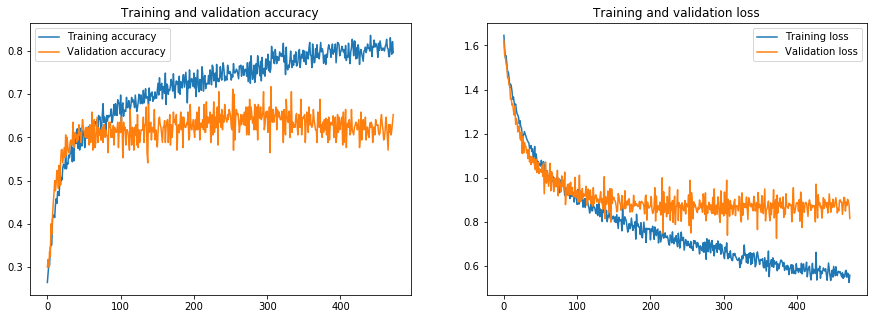

In [0]:
plot_accuracy_and_loss(history)

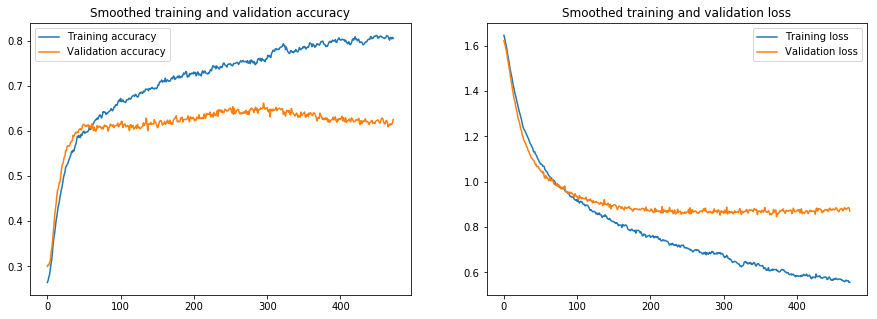

In [0]:
plot_smoothed_acc_and_loss(history, 0.8)

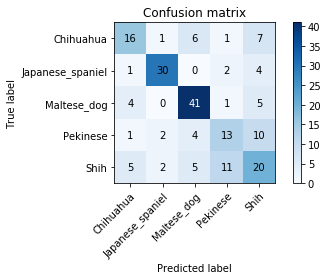

In [0]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

### Data preparation

In [12]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 6046 images belonging to 60 classes.
Found 2019 images belonging to 60 classes.
Found 2046 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

### Model

In [13]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [14]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_60', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_60_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 42s - loss: 4.0717 - acc: 0.0334 - val_loss: 3.9433 - val_acc: 0.0645

Epoch 00001: val_loss improved from inf to 3.94329, saving model to tl_freeze_conv_base_data_aug_60
Epoch 2/1000
 - 42s - loss: 3.8835 - acc: 0.0840 - val_loss: 3.7847 - val_acc: 0.0930

Epoch 00002: val_loss improved from 3.94329 to 3.78474, saving model to tl_freeze_conv_base_data_aug_60
Epoch 3/1000
 - 40s - loss: 3.7153 - acc: 0.1137 - val_loss: 3.6379 - val_acc: 0.1181

Epoch 00003: val_loss improved from 3.78474 to 3.63790, saving model to tl_freeze_conv_base_data_aug_60
Epoch 4/1000
 - 40s - loss: 3.5852 - acc: 0.1391 - val_loss: 3.5470 - val_acc: 0.1246

Epoch 00004: val_loss improved from 3.63790 to 3.54704, saving model to tl_freeze_conv_base_data_aug_60
Epoch 5/1000
 - 40s - loss: 3.4700 - acc: 0.1487 - val_loss: 3.4608 - val_acc: 0.1426

Epoch 00005: val_loss improved from 3.54704 to 3.46080, saving model to tl_freeze_conv_base_data_aug_60
Epoch 6/1000
 - 40s - loss: 3.3720 - acc: 0.1688 

 - 40s - loss: 2.3130 - acc: 0.3827 - val_loss: 2.9039 - val_acc: 0.2611

Epoch 00051: val_loss did not improve from 2.81425
Epoch 52/1000
 - 40s - loss: 2.3202 - acc: 0.3841 - val_loss: 2.9002 - val_acc: 0.2721

Epoch 00052: val_loss did not improve from 2.81425
Epoch 53/1000
 - 40s - loss: 2.3074 - acc: 0.3910 - val_loss: 2.9132 - val_acc: 0.2616

Epoch 00053: val_loss did not improve from 2.81425
Epoch 54/1000
 - 40s - loss: 2.3153 - acc: 0.3925 - val_loss: 2.9098 - val_acc: 0.2656

Epoch 00054: val_loss did not improve from 2.81425
Epoch 55/1000
 - 40s - loss: 2.2934 - acc: 0.3919 - val_loss: 2.8901 - val_acc: 0.2746

Epoch 00055: val_loss did not improve from 2.81425
Epoch 56/1000
 - 40s - loss: 2.2911 - acc: 0.3858 - val_loss: 2.8518 - val_acc: 0.2631

Epoch 00056: val_loss did not improve from 2.81425
Epoch 57/1000
 - 40s - loss: 2.2514 - acc: 0.4025 - val_loss: 2.9225 - val_acc: 0.2711

Epoch 00057: val_loss did not improve from 2.81425
Epoch 58/1000
 - 40s - loss: 2.2509 - acc

### Results

In [15]:
model.evaluate(test_features, test_labels)

2046/2046 [==============================] - 9s 4ms/step


[2.8773776401172984, 0.2649071360205392]

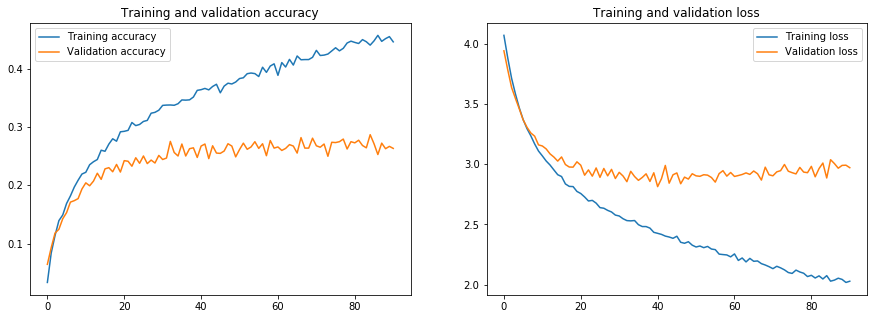

In [16]:
plot_accuracy_and_loss(history)

# 120 breeds

### Data preparation

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 12307 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

### Model

In [19]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [20]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_120', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_120_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 83s - loss: 4.7567 - acc: 0.0214 - val_loss: 4.6203 - val_acc: 0.0405

Epoch 00001: val_loss improved from inf to 4.62029, saving model to tl_freeze_conv_base_data_aug_120
Epoch 2/1000
 - 84s - loss: 4.5440 - acc: 0.0523 - val_loss: 4.3977 - val_acc: 0.0704

Epoch 00002: val_loss improved from 4.62029 to 4.39769, saving model to tl_freeze_conv_base_data_aug_120
Epoch 3/1000
 - 82s - loss: 4.3471 - acc: 0.0756 - val_loss: 4.2315 - val_acc: 0.0890

Epoch 00003: val_loss improved from 4.39769 to 4.23153, saving model to tl_freeze_conv_base_data_aug_120
Epoch 4/1000
 - 82s - loss: 4.1941 - acc: 0.0953 - val_loss: 4.0919 - val_acc: 0.1039

Epoch 00004: val_loss improved from 4.23153 to 4.09188, saving model to tl_freeze_conv_base_data_aug_120
Epoch 5/1000
 - 82s - loss: 4.0626 - acc: 0.1109 - val_loss: 4.0011 - val_acc: 0.1164

Epoch 00005: val_loss improved from 4.09188 to 4.00107, saving model to tl_freeze_conv_base_data_aug_120
Epoch 6/1000
 - 82s - loss: 3.9571 - acc: 0.

 - 82s - loss: 2.8860 - acc: 0.3002 - val_loss: 3.5359 - val_acc: 0.2119

Epoch 00051: val_loss did not improve from 3.43112
Epoch 52/1000
 - 82s - loss: 2.9164 - acc: 0.2912 - val_loss: 3.4997 - val_acc: 0.2088

Epoch 00052: val_loss did not improve from 3.43112
Epoch 53/1000
 - 82s - loss: 2.8924 - acc: 0.2999 - val_loss: 3.4935 - val_acc: 0.2158

Epoch 00053: val_loss did not improve from 3.43112
Epoch 54/1000
 - 82s - loss: 2.8847 - acc: 0.2949 - val_loss: 3.4832 - val_acc: 0.2163

Epoch 00054: val_loss did not improve from 3.43112
Epoch 55/1000
 - 82s - loss: 2.8653 - acc: 0.3013 - val_loss: 3.5047 - val_acc: 0.2063

Epoch 00055: val_loss did not improve from 3.43112
Epoch 56/1000
 - 82s - loss: 2.8824 - acc: 0.3088 - val_loss: 3.4893 - val_acc: 0.2119

Epoch 00056: val_loss did not improve from 3.43112
Epoch 57/1000
 - 82s - loss: 2.8484 - acc: 0.3113 - val_loss: 3.4977 - val_acc: 0.2095

Epoch 00057: val_loss did not improve from 3.43112
Epoch 58/1000
 - 82s - loss: 2.8409 - acc

### Results

In [21]:
model.evaluate(test_features, test_labels)

4162/4162 [==============================] - 16s 4ms/step


[3.392012827560227, 0.219365689572321]

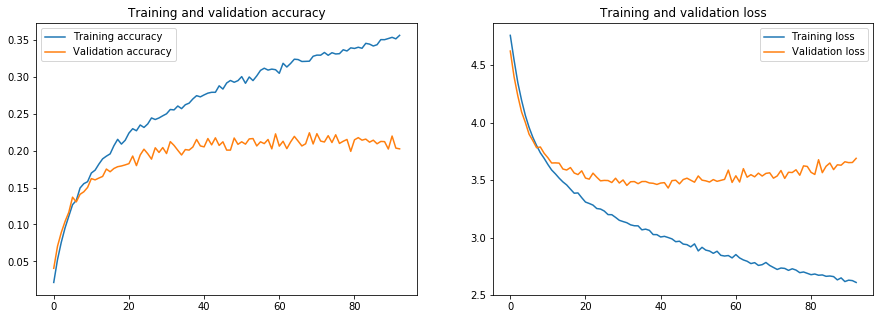

In [22]:
plot_accuracy_and_loss(history)